# **Imorting Necessary Libraries**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Difining the Paths for Training, Validation, and Testing Data**

In [3]:
train_path = '/content/drive/MyDrive/chest_xray/train'
val_path = '/content/drive/MyDrive/chest_xray/val'
test_path = '/content/drive/MyDrive/chest_xray/test'

# **Visualizing the data**

In [4]:
normal_train_images = glob.glob(train_path + "/NORMAL/*.jpeg")
pneumonia_train_images = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

In [5]:
print(len(normal_train_images))
print(len(pneumonia_train_images))

1341
3875


In [6]:
data = pd.DataFrame(np.concatenate([[0] * len(normal_train_images) , [1] *  len(pneumonia_train_images)]), columns = ["class"])

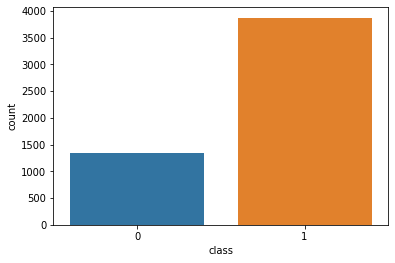

In [7]:
sns.countplot(x = 'class', data = data)

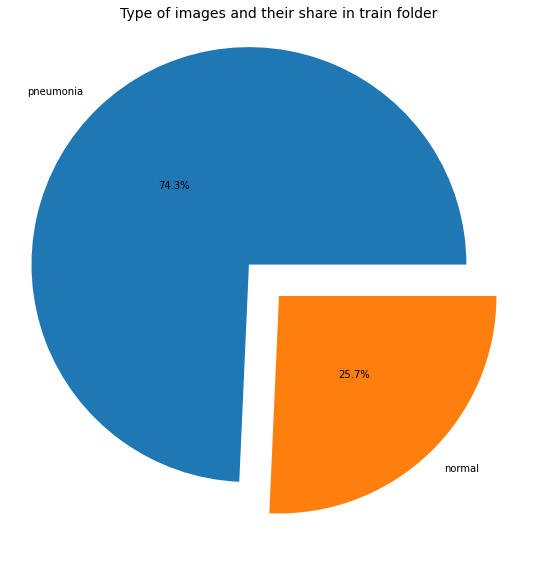

In [8]:
plt.figure(figsize = (15, 10))
plt.pie(x = np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct = "%.1f%%", explode = [0.2, 0], labels = ["pneumonia", "normal"], pctdistance = 0.5)
plt.title("Type of images and their share in train folder", fontsize = 14);

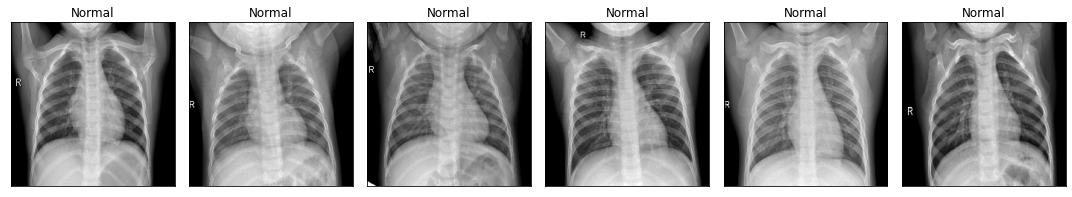

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()

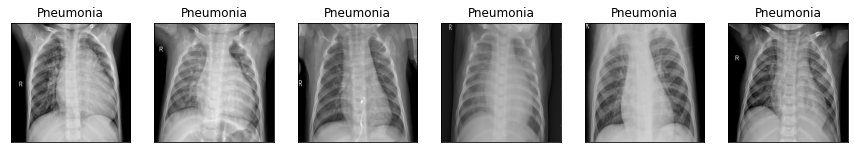

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512, 512))
    ax.imshow(img)
    ax.set_title("Pneumonia")
    
plt.show()

# **Creating Image Data Generators**

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (220, 220),
    batch_size = 16,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        test_path,
        target_size = (220,220),
        batch_size = 8,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
    val_path,
    shuffle = False,
    target_size = (220,220),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **Defining the Model**

In [13]:
input_shape = (220, 220, 3)

base_model = tf.keras.applications.VGG16(weights = 'imagenet', input_shape = input_shape, include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

58892288/58889256 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
_________________________________________________________________


# **Training the Model**

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10, callbacks = callback)

Epoch 1/10
100/100 [==============================] - 1094s 11s/step - loss: 0.3775 - accuracy: 0.8381 - val_loss: 0.3828 - val_accuracy: 0.8333
Epoch 2/10
100/100 [==============================] - 1093s 11s/step - loss: 0.2616 - accuracy: 0.8944 - val_loss: 0.3380 - val_accuracy: 0.8622
Epoch 3/10
100/100 [==============================] - 1097s 11s/step - loss: 0.2296 - accuracy: 0.9013 - val_loss: 0.3227 - val_accuracy: 0.8686
Epoch 4/10
100/100 [==============================] - 1102s 11s/step - loss: 0.2146 - accuracy: 0.9125 - val_loss: 0.3261 - val_accuracy: 0.8606
Epoch 5/10
100/100 [==============================] - 1111s 11s/step - loss: 0.2208 - accuracy: 0.9112 - val_loss: 0.3007 - val_accuracy: 0.8878
Epoch 6/10
100/100 [==============================] - 1110s 11s/step - loss: 0.1879 - accuracy: 0.9212 - val_loss: 0.3177 - val_accuracy: 0.8830
Epoch 7/10
100/100 [==============================] - 1110s 11s/step - loss: 0.1984 - accuracy: 0.9181 - val_loss: 0.2945 - val_ac

# **Saving the Model**

In [16]:
model.save("model1")

INFO:tensorflow:Assets written to: model1/assets


# **Model Metrics**

In [17]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# **Visualizing Accuracy and Loss**

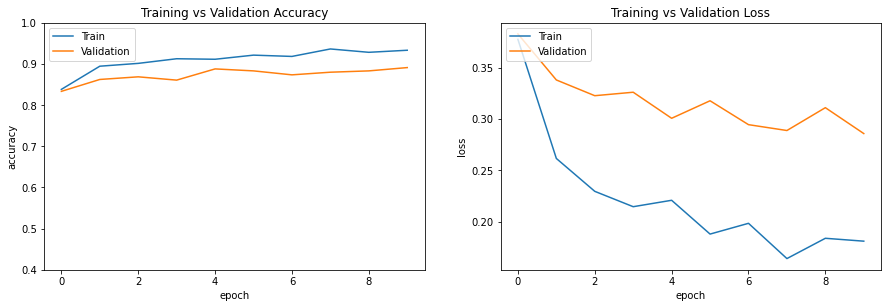

In [18]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# **Predictions**

In [19]:
model = tf.keras.models.load_model('model1')

In [20]:
pred = model.predict(test_generator)

In [21]:
pred

array([[0.94955647],
       [0.15155241],
       [0.7428619 ],
       [0.08119708],
       [0.8847958 ],
       [0.87579405],
       [0.02293599],
       [0.05420783],
       [0.99645126],
       [0.9894905 ],
       [0.9913863 ],
       [0.77305114],
       [0.9390143 ],
       [0.99878   ],
       [0.99662316],
       [0.9786749 ]], dtype=float32)

In [22]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [23]:
y_pred

[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [24]:
y_true = test_generator.classes

In [25]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# **Confusion Matrix**

In [26]:
cm = confusion_matrix(y_true, y_pred)

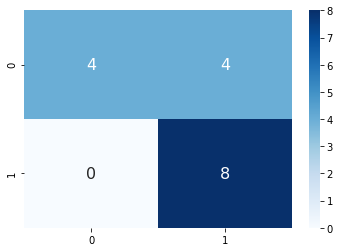

In [27]:
sns.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size": 16})

# **Classification Report**

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



# **Analysing the Results**

In [29]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [30]:
confusion

['FP',
 'TN',
 'FP',
 'TN',
 'FP',
 'FP',
 'TN',
 'TN',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP']

In [31]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,FP
1,TN
2,FP
3,TN
4,FP
5,FP
6,TN
7,TN
8,TP
9,TP


In [32]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,1,0,FP
1,0,0,TN
2,1,0,FP
3,0,0,TN
4,1,0,FP
5,1,0,FP
6,0,0,TN
7,0,0,TN
8,1,1,TP
9,1,1,TP


In [33]:
confusion_table.Results == 'FP'

0      True
1     False
2      True
3     False
4      True
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
Name: Results, dtype: bool

In [34]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
0,1,0,FP
2,1,0,FP
4,1,0,FP
5,1,0,FP


In [35]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results


In [36]:
normal_test_images = glob.glob(val_path + "/NORMAL/*.jpeg")
pneumonia_test_images = glob.glob(val_path + "/PNEUMONIA/*.jpeg")

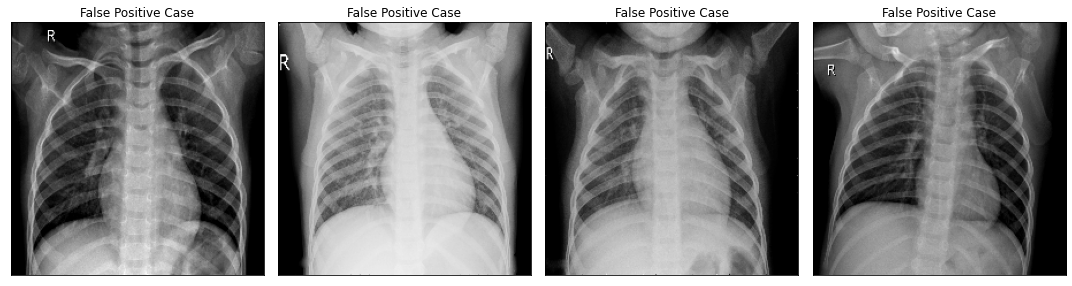

In [37]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip([0, 2, 4, 5], axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

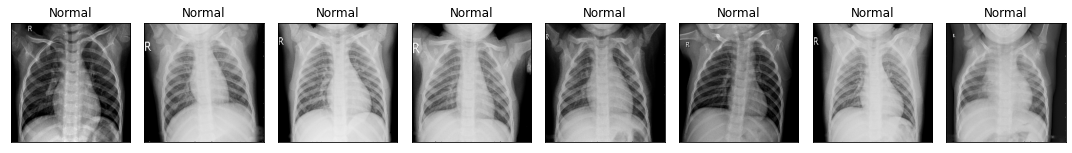

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()